# Preparing the Data for Linear Regression

In this notebook we add features to our dataset to prepare it for our linear regression algorithims. 

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
from talib import RSI, BBANDS, MACD, ATR

We set the month variable equal to the average amount of trading days in a month

In [3]:
MONTH = 21
YEAR = 12

We set the start and end dates to the beginning and ending of our date index.

In [4]:
START = '2019-01-01'
END = '2021-01-06'

In [5]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Loading Stock Prices 

We load the `h5` data from our earlier notebook

In [6]:
DATA_STORE = '../Data_Processing/Data/H5/assets.h5'
ohlcv = ['Open', 'Close', 'Low', 'High', 'Volume']

with pd.HDFStore(DATA_STORE) as store:
    prices = (store['Alt_Energy/prices']
              .loc[idx[START:END, :], ohlcv]
              .swaplevel()
              .sort_index())
    
    ## Normalize the value of the stocks volume
    prices.Volume /= 1000

## Compute Rolling Average Dollar Volume

This script calculates the mean dollar volume for the average trading month.

In [7]:
prices['dollar_vol'] = prices.loc[:, 'Close'].mul(prices.loc[:, 'Volume'], axis=0)

prices['dollar_vol'] = (prices.groupby('Ticker', group_keys = False, as_index = False)
                        .dollar_vol
                        .rolling(window = 21)
                        .mean()
                        .fillna(0)
                        .reset_index(level=0, drop=True))

prices.dollar_vol /= 1000

In [8]:
prices.head()

Open  Close    Low   High  Volume  dollar_vol
Ticker Date                                                      
BE     2019-01-07  11.86  12.41  11.86  13.24   391.6         0.0
       2019-01-08  13.00  12.73  12.47  13.25   329.5         0.0
       2019-01-09  12.80  12.14  12.01  13.63   643.5         0.0
       2019-01-10  12.09  12.02  11.66  12.38   474.5         0.0
       2019-01-11  11.84  12.24  11.81  12.69   387.7         0.0

Sort stocks by volume rank

In [9]:
prices['dollar_vol_rank'] = (prices.groupby('Date').dollar_vol.rank(ascending=False))

In [10]:
prices.head()

Open  Close    Low   High  Volume  dollar_vol  \
Ticker Date                                                         
BE     2019-01-07  11.86  12.41  11.86  13.24   391.6         0.0   
       2019-01-08  13.00  12.73  12.47  13.25   329.5         0.0   
       2019-01-09  12.80  12.14  12.01  13.63   643.5         0.0   
       2019-01-10  12.09  12.02  11.66  12.38   474.5         0.0   
       2019-01-11  11.84  12.24  11.81  12.69   387.7         0.0   

                   dollar_vol_rank  
Ticker Date                         
BE     2019-01-07              6.0  
       2019-01-08              6.0  
       2019-01-09              6.0  
       2019-01-10              6.0  
       2019-01-11              6.0

## Add some Basic Factors

### Compute the Relative Strength Index

The relative strength index is a technical indicator used in the analysis of financial markets. It is intended to chart the current and historical strength or weakness of a stock based on the closing prices of a recent trading period. The RSI is displayed as an oscillator (a line graph that moves between two extremes) and can have a reading from 0 to 100. The RSI moves closer to 100 as the market trends move closer to absolute growth.

We see that most growth falls in the 30-70 range.

In [11]:
prices['rsi'] = prices.groupby(level='Ticker').Close.apply(RSI)

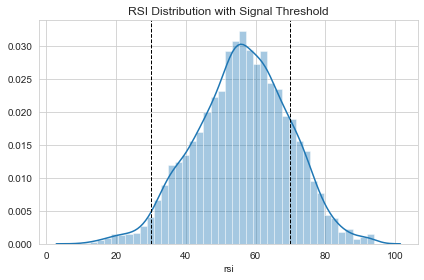

In [12]:
ax = sns.distplot(prices.rsi.dropna())

ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')

ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout();

### Compute Bollinger Bands

Bollinger Bands are a type of statistical chart characterizing the prices and volatility over time. Common trading strategies involing buying and selling as stocks oscillate between the upper and lower bands.

In [13]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod = 21)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [14]:
prices = (prices.join(prices.groupby(level='Ticker').Close.apply(compute_bb)))

In [15]:
prices['bb_high'] = prices.bb_high.sub(prices.Close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.Close.sub(prices.bb_low).div(prices.Close).apply(np.log1p)

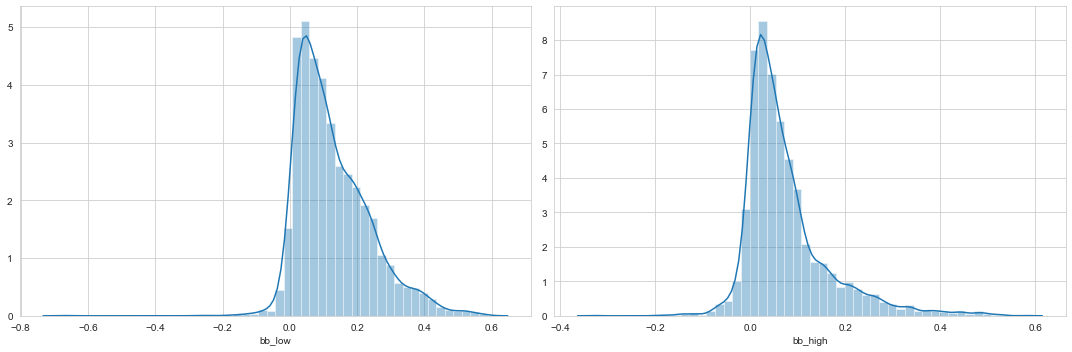

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])

plt.tight_layout();

### Compute Average True Range

The average true range (ATR) is a technical analysis indicator that measures market volatility by decomposing the entire range of an asset price for that period.

In [17]:
def compute_atr(stock_data):
    df = ATR(stock_data.High, stock_data.Low, stock_data.Close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

In [18]:
prices['atr'] = (prices.groupby('Ticker', group_keys=False)
                 .apply(compute_atr))

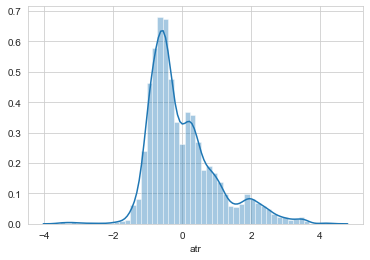

In [19]:
sns.distplot(prices.atr.dropna());

### Compute Moving Average Convergence/Divergence

Moving average convergence divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of a equity’s price. The MACD is calculated by subtracting the 26-period exponential moving average (EMA) from the 12-period EMA.

In [20]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

In [21]:
prices['macd'] = (prices.groupby('Ticker', group_keys=False).Close.apply(compute_macd))

In [22]:
prices.macd.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')

count    5,181.0
mean        -0.0
std          1.0
min         -5.6
0.1%        -4.4
1%          -2.5
2%          -2.0
3%          -1.8
4%          -1.6
5%          -1.5
50%         -0.1
95%          1.8
96%          1.9
97%          2.1
98%          2.4
99%          2.8
99.9%        3.9
max          5.2
Name: macd, dtype: object

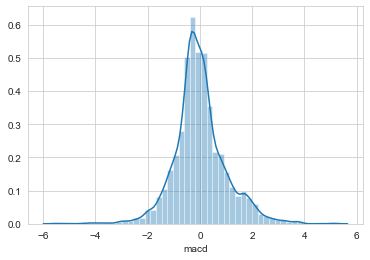

In [23]:
sns.distplot(prices.macd.dropna());

## Compute Lagged Returns

In [24]:
lags = [1, 5, 10, 21, 42, 63]

In [25]:
returns = prices.groupby(level='Ticker').Close.pct_change()

percentiles = [.0001, .001, .01]

percentiles += [1 - p for p in percentiles]

returns.describe(percentiles = percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

,percentiles
std,4.26%
min,-42.50%
0.01%,-33.37%
0.1%,-22.64%
1%,-11.16%
50%,0.14%
99%,13.05%
99.9%,31.12%
99.99%,44.97%
max,45.59%


In [26]:
q = 0.001

### Winsorize outliers

This removes outliers.

We then shift the daily, weekly, and monthly returns to use them as features for the current observations. In other words, in addition to the latest returns for these periods, we also use the prior five results.

In [27]:
for lag in lags:
    prices[f'return_{lag}d'] = (prices.groupby(level='Ticker').Close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )

### Shift lagged returns and compute forward returns

In [28]:
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        prices[f'return_{lag}d_lag{t}'] = (prices.groupby(level='Ticker')
                                           [f'return_{lag}d'].shift(t * lag))

In [29]:
for t in [1, 5, 10, 21]:
    prices[f'target_{t}d'] = prices.groupby(level='Ticker')[f'return_{t}d'].shift(-t)

## Create time variables

We need to convert any categorical variable into a numeric format so that the linear regression can process it. For this purpose, we will use a dummy encoding that creates individual columns for each category level and flags the presence of this level in the original categorical column

In [30]:
prices['day'] = prices.index.get_level_values('Date').dayofweek
prices['month'] = prices.index.get_level_values('Date').month
prices['year'] = prices.index.get_level_values('Date').year

In [31]:
prices = pd.get_dummies(prices, columns=['year', 'month', 'day'], 
                        prefix=['year', 'month', 'day'], 
                        prefix_sep = ['_', '_', '_'])

## Store Model Data

In [32]:
prices.to_hdf('data.h5', 'model_data')